In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))

    e = np.sum((np.abs((zr-np.real(ztot))))/(np.abs(zmag))) + \
        np.sum((np.abs((zj-np.abs(np.imag(ztot)))))/(np.abs(zmag)))

    L1 = e / n
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'rj_nolog.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zr_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'r.png', dpi=300, bbox_inches='tight')
    
    # residual plots
    plt.figure()
    plt.title(title)
    plt.plot(f, (zj-zj_l1)/zj, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zj-zj_l2)/zj, 's-', label='Log10 L2 norm')
    plt.plot(f, (zj-zj_linf)/zj, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zj-zj_lk)/zj, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'j_resid.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, (zr-zr_l1)/zr, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zr-zr_l2)/zr, 's-', label='Log10 L2 norm')
    plt.plot(f, (zr-zr_linf)/zr, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zr-zr_lk)/zr, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'r_resid.png', dpi=300, bbox_inches='tight')
    plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
    solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
                             limits=bounds, minimize=True)
#     solver = pyfde.JADE(obj_function, n_dim=5, n_pop=50,
#                         limits=bounds, minimize=True)
#     solver.c = np.random.random()
#     solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        # print('Polish was better')
    else:
        opts = fit
        results_x = best
        # print('Polish did not help')
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=50, n_proc=8):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
#     print('Paramters:', results_x)
#     print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Best Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


# Parasitic Capacitance Values for Wires
wire_c = 741.0e-12  # capacitance value measured for Autolab 



# Optimization on artifical solution
Run the optimization on known paramter values

Optimization runtime 78.7358 seconds
Best Objective value: 2.0193624550302048e-14
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 6.09621153e+29
 8.90002955e+01] 



Optimization runtime 69.9433 seconds
Best Objective value: 5.988856088472392e-14
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 1.00000000e+30
 8.90002613e+01] 



Optimization runtime 70.4934 seconds
Best Objective value: 1.8741523145753918e-14
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 1.00000000e+30
 8.90002951e+01] 



Optimization runtime 63.4015 seconds
Best Objective value: 2.1902741762573135e-43
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 4.86592716e+29
 8.90002838e+01] 





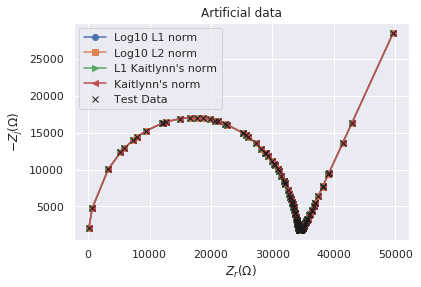

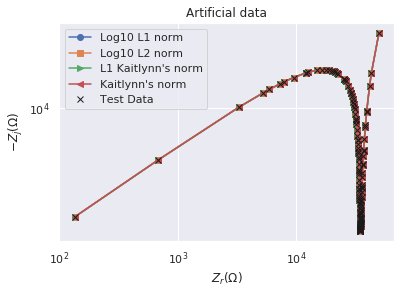

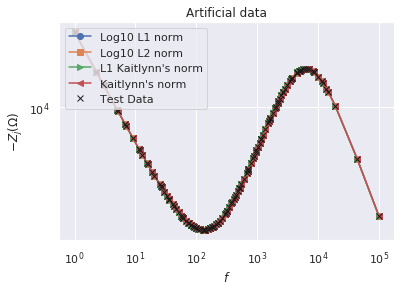

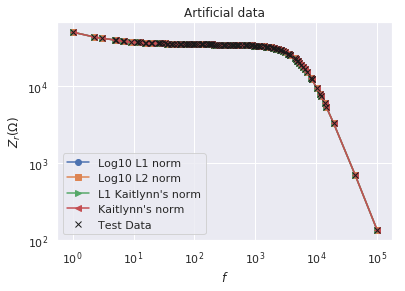

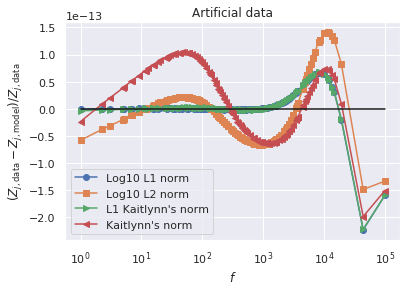

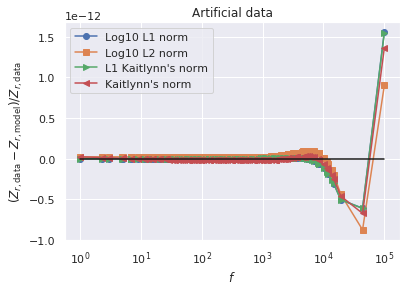

In [2]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
     'Artificial data')

# Run optimization on Blue Test Data

Optimization runtime 74.3275 seconds
Best Objective value: 0.12972955030602534
Best Paramters: [4.38271656e-01 5.63600595e-01 2.44157780e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 68.1933 seconds
Best Objective value: 0.22918188382102644
Best Paramters: [4.45693723e-01 5.35020862e-01 1.63359071e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 69.6009 seconds
Best Objective value: 0.16421638621101214
Best Paramters: [4.38023393e-01 5.65634454e-01 2.46059577e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 63.4165 seconds
Best Objective value: 1300291794.6563134
Best Paramters: [4.99877361e-01 4.74498681e-01 3.49009326e+01 1.00000000e-04
 1.01562528e-10] 





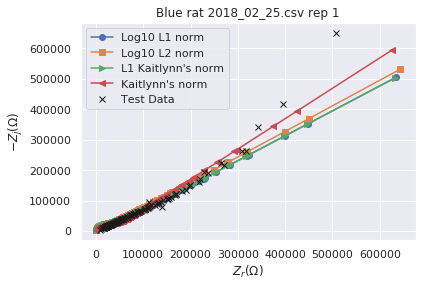

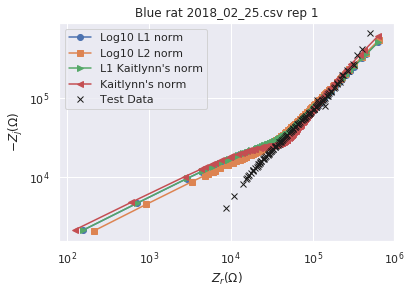

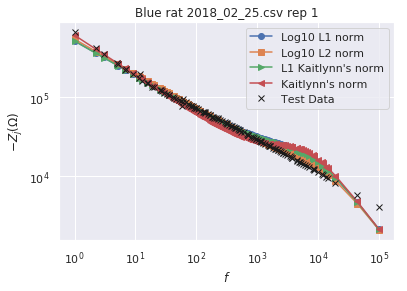

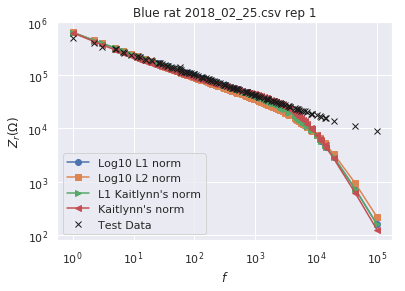

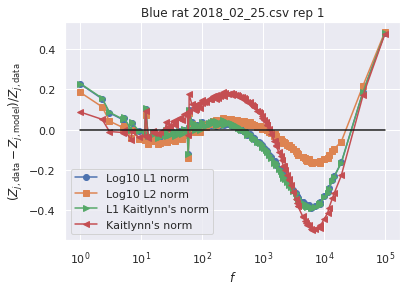

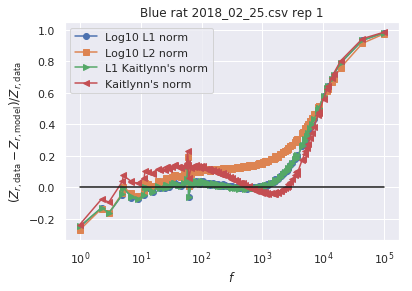

Optimization runtime 73.6720 seconds
Best Objective value: 0.13555322999824748
Best Paramters: [4.42068657e-01 5.47550093e-01 2.72485969e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 68.1635 seconds
Best Objective value: 0.23989569540426403
Best Paramters: [4.47188384e-01 5.26118544e-01 1.77305882e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 69.7338 seconds
Best Objective value: 0.1684996351892746
Best Paramters: [4.41956205e-01 5.48567228e-01 2.74422631e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 63.8658 seconds
Best Objective value: 2083328207.2880511
Best Paramters: [5.20781153e-01 4.45895683e-01 4.19611955e+01 1.00000000e-04
 1.00000000e-10] 





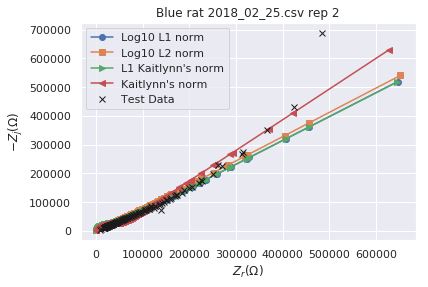

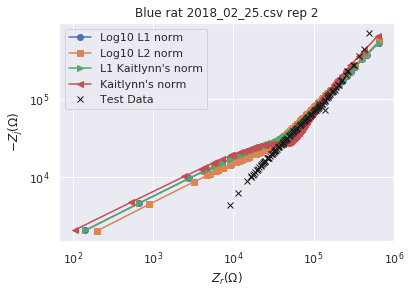

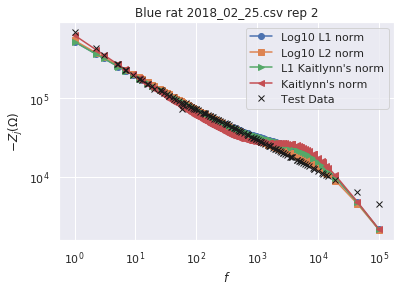

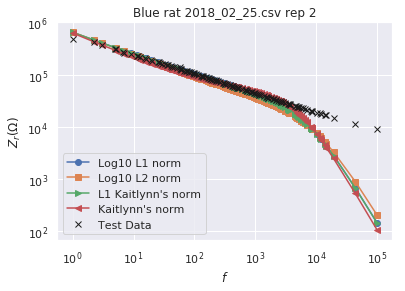

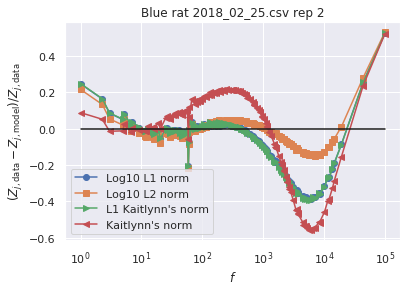

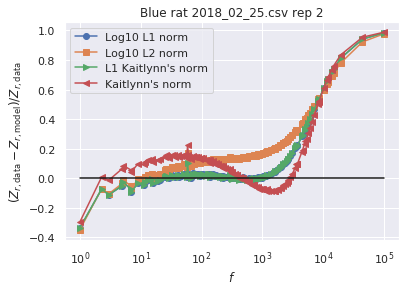

Optimization runtime 89.5197 seconds
Best Objective value: 0.2795582534100929
Best Paramters: [5.09264576e-01 4.16516430e-01 4.24848694e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 82.5639 seconds
Best Objective value: 0.3562511595249325
Best Paramters: [5.21542649e-01 3.39414436e-01 2.39660815e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 80.7924 seconds
Best Objective value: 0.3182036284546998
Best Paramters: [5.07886318e-01 4.26320970e-01 4.47313925e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 75.3930 seconds
Best Objective value: 768999885605.4009
Best Paramters: [5.32448199e-01 2.92640428e-01 4.56220420e+01 1.00000000e-04
 7.81325529e-07] 





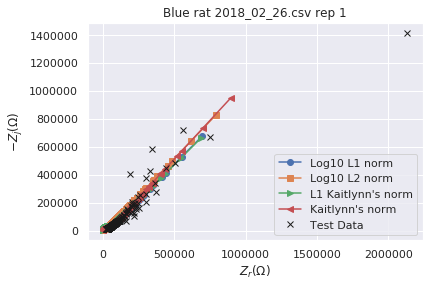

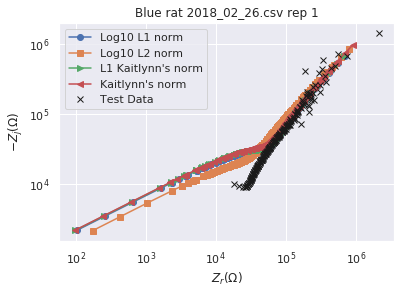

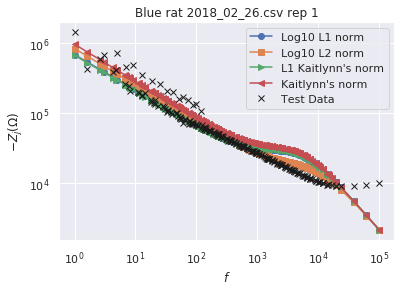

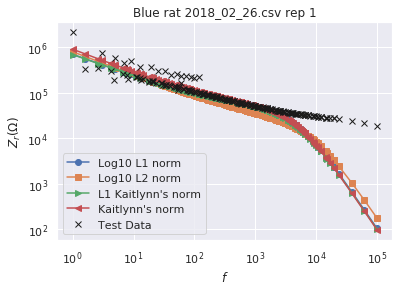

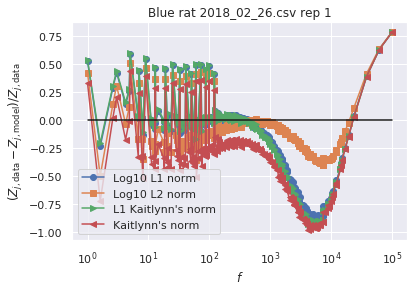

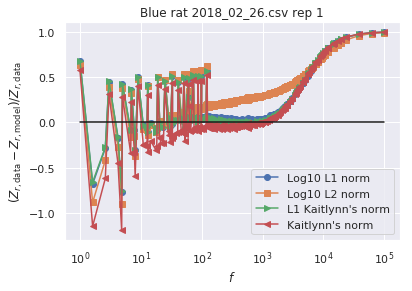

Optimization runtime 88.9118 seconds
Best Objective value: 0.2795582534100927
Best Paramters: [5.09264576e-01 4.16516430e-01 4.24848694e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 82.6264 seconds
Best Objective value: 0.3562511595249325
Best Paramters: [5.21542649e-01 3.39414435e-01 2.39660814e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 81.1179 seconds
Best Objective value: 0.3182036284547
Best Paramters: [5.07886318e-01 4.26320970e-01 4.47313925e+01 1.00000000e-04
 4.34238892e-07] 



Optimization runtime 75.1854 seconds
Best Objective value: 768999885605.403
Best Paramters: [5.32448206e-01 2.92640428e-01 4.56220494e+01 1.00000000e-04
 1.21750040e-06] 





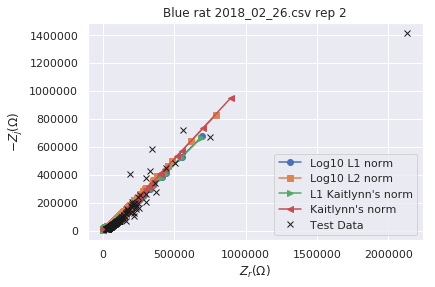

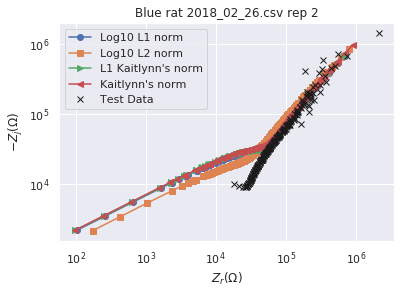

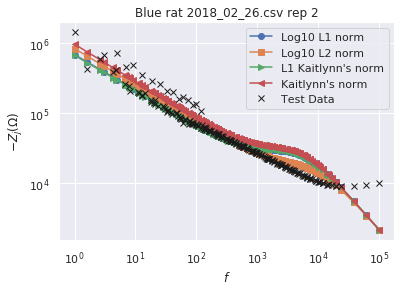

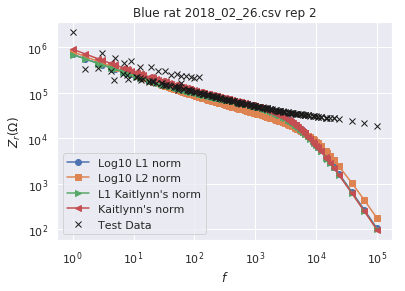

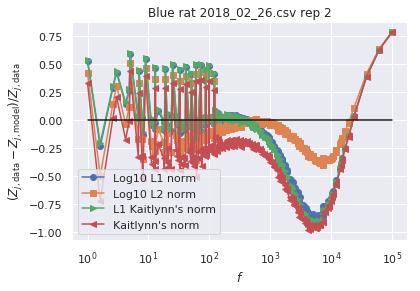

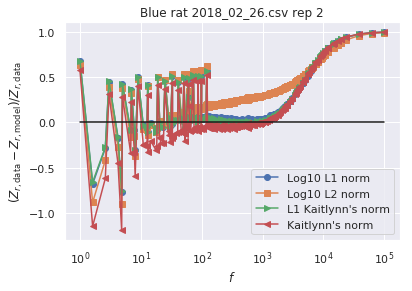

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log10


Optimization runtime 88.8116 seconds
Best Objective value: 0.8988487129468083
Best Paramters: [3.85163632e-01 5.02086601e-02 1.08889408e+02 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 82.7287 seconds
Best Objective value: 0.8664843963929225
Best Paramters: [5.90497495e-01 2.78054662e-02 6.88712365e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 81.7446 seconds
Best Objective value: 0.5569302161991274
Best Paramters: [2.25242310e-01 8.11297922e-02 1.00000000e-02 1.00000000e-04
 9.99999690e+02] 



Optimization runtime 74.4422 seconds
Best Objective value: 14749302545246.598
Best Paramters: [4.85120912e-02 1.70295803e-01 1.00000000e-02 9.82648910e+29
 9.99999981e+02] 





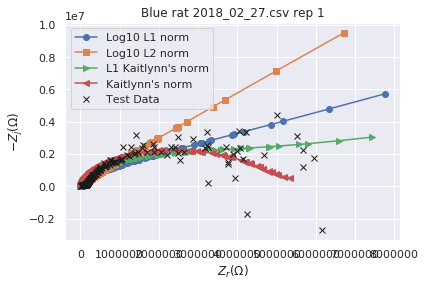

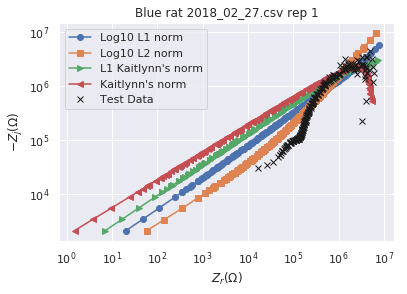

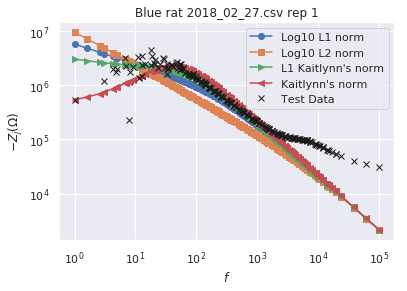

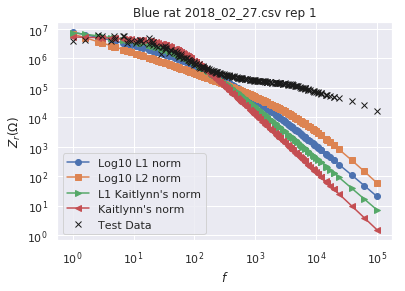

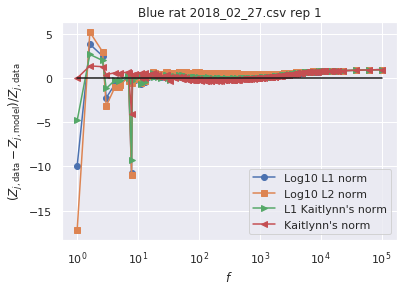

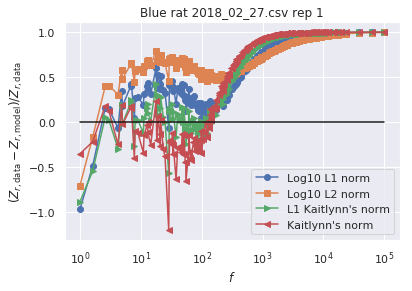

Optimization runtime 88.8062 seconds
Best Objective value: 0.9195005019366633
Best Paramters: [3.57435664e-01 6.09370499e-02 8.12868032e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 82.7974 seconds
Best Objective value: 0.8766554096920847
Best Paramters: [5.76421339e-01 3.12255261e-02 6.74082745e+01 1.00000000e-04
 1.00030723e-10] 



Optimization runtime 80.6356 seconds
Best Objective value: 0.5624266295199726
Best Paramters: [2.20846971e-01 8.14411282e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 



Optimization runtime 73.8247 seconds
Best Objective value: 30661129018627.734
Best Paramters: [3.67444739e-02 1.49813812e-01 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





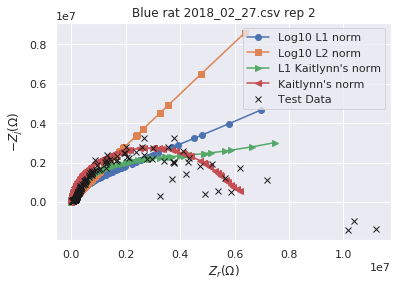

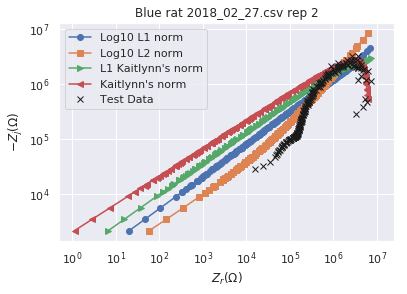

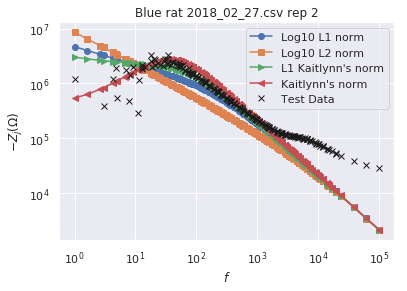

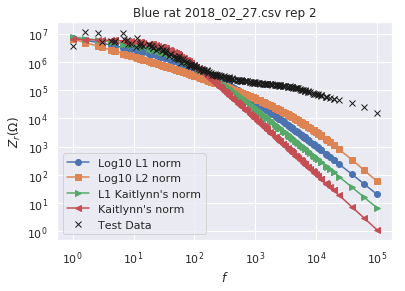

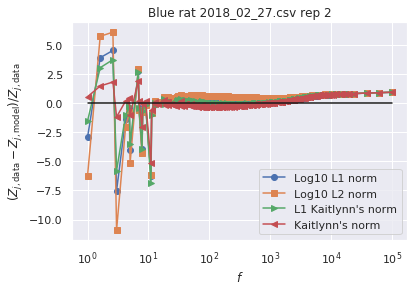

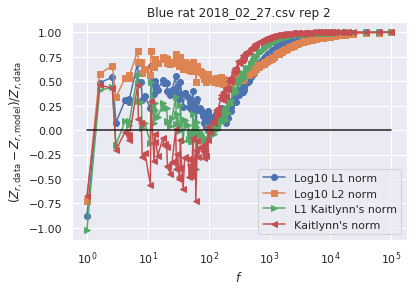

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10


Optimization runtime 84.8164 seconds
Best Objective value: 0.9494671323913462
Best Paramters: [5.72296640e-01 2.01167518e-02 2.08390302e+02 1.00000000e-04
 1.00000001e-10] 



Optimization runtime 78.8076 seconds
Best Objective value: 0.8142361540493398
Best Paramters: [6.65210013e-01 1.55129630e-02 8.61401365e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 79.1091 seconds
Best Objective value: 0.8337218799124232
Best Paramters: [2.00193591e+00 6.69120661e-03 9.99997729e+02 7.21727101e+28
 5.53027404e-06] 



Optimization runtime 74.1706 seconds
Best Objective value: 2111250955325494.0
Best Paramters: [3.13949688e-01 6.24542006e-01 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





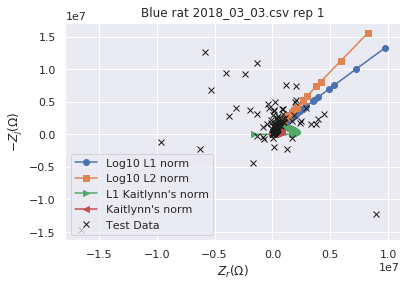

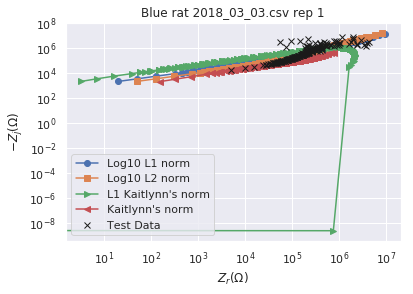

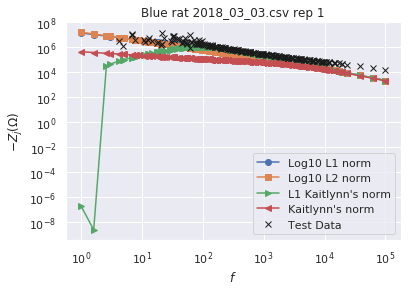

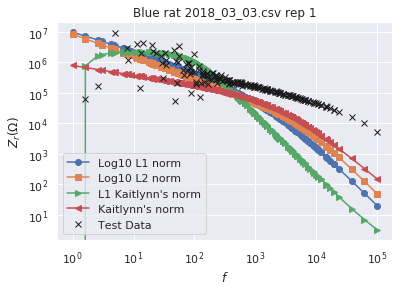

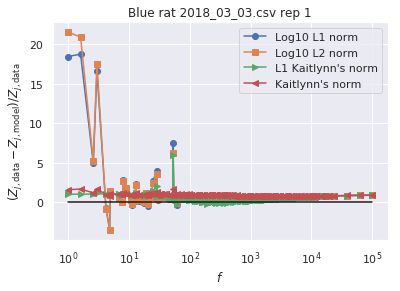

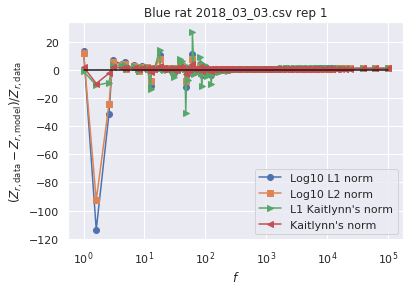

Optimization runtime 85.5809 seconds
Best Objective value: 0.9451298238463759
Best Paramters: [5.45227079e-01 2.28103706e-02 1.92713406e+02 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 79.0577 seconds
Best Objective value: 0.8186165319136266
Best Paramters: [6.39783687e-01 1.74337713e-02 8.36404570e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 80.6584 seconds
Best Objective value: 0.8244703470280969
Best Paramters: [8.09935636e-02 4.05053448e-01 7.30311117e+02 8.59339860e+29
 4.33834739e+02] 



Optimization runtime 73.7819 seconds
Best Objective value: 1427201912700581.8
Best Paramters: [1.33214611e-01 5.03103944e-01 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





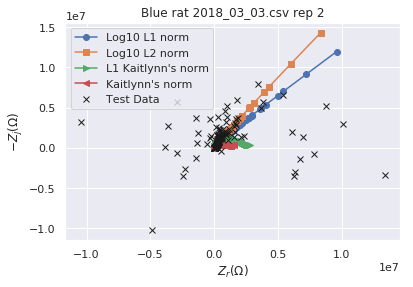

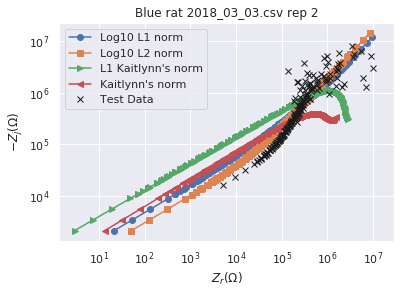

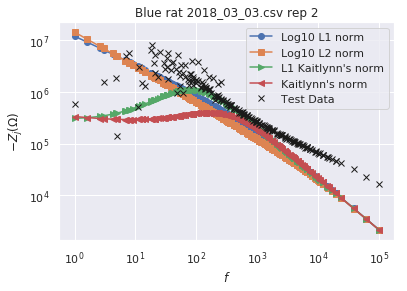

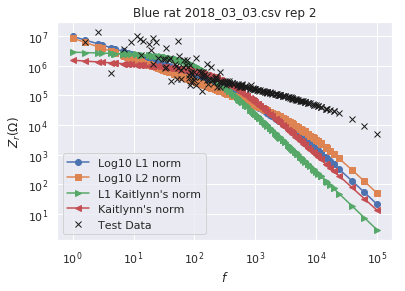

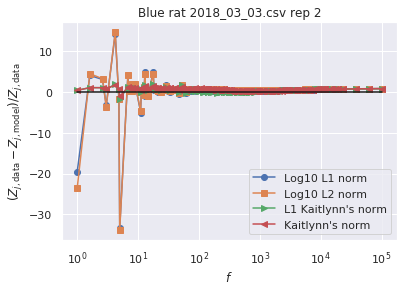

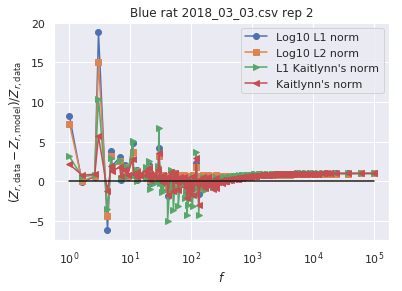

Optimization runtime 83.9075 seconds
Best Objective value: 1.106472434882809
Best Paramters: [5.29470233e-01 4.15727035e-02 1.56969649e+02 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 77.3623 seconds
Best Objective value: 0.9431237607219415
Best Paramters: [6.07151513e-01 4.60798121e-02 7.34933161e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 77.4861 seconds
Best Objective value: 0.72617601408322
Best Paramters: [6.49642921e-01 2.48058533e-02 6.24929626e+02 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 70.8391 seconds
Best Objective value: 1349814486751.7708
Best Paramters: [5.33189269e-01 3.02950071e-02 4.40626685e+02 1.00000000e-04
 1.00000000e-10] 





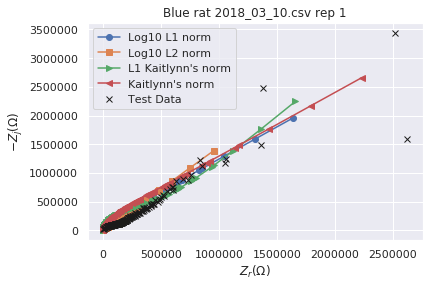

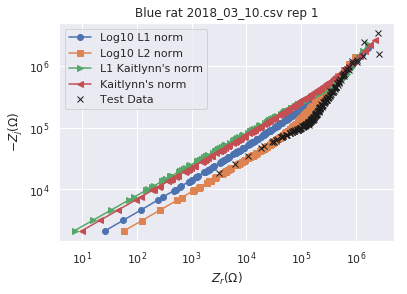

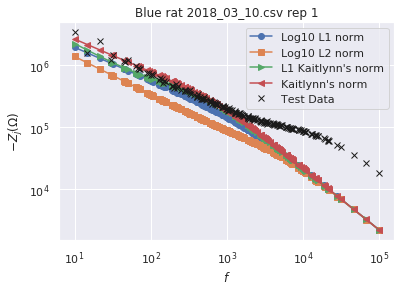

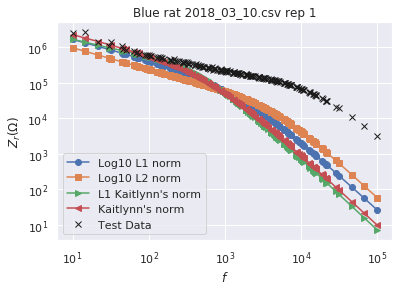

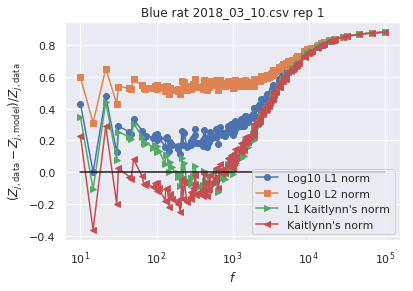

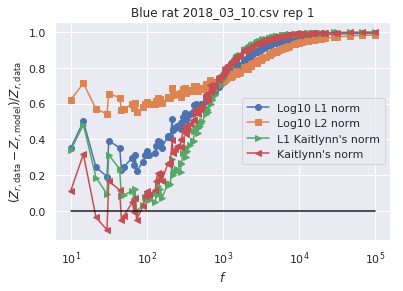

Optimization runtime 83.4657 seconds
Best Objective value: 1.1002083411988188
Best Paramters: [5.04090308e-01 5.09032929e-02 1.50445513e+02 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 77.1529 seconds
Best Objective value: 0.9427669694531403
Best Paramters: [6.09113513e-01 4.60914133e-02 7.30137147e+01 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 77.5526 seconds
Best Objective value: 0.7284699975594143
Best Paramters: [6.39627005e-01 2.46963891e-02 5.80596498e+02 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 70.8717 seconds
Best Objective value: 1493452402268.2202
Best Paramters: [4.10149905e-01 5.52622737e-02 2.62212500e+02 1.00000000e-04
 1.00000000e-10] 





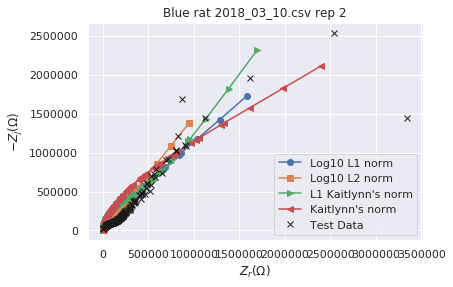

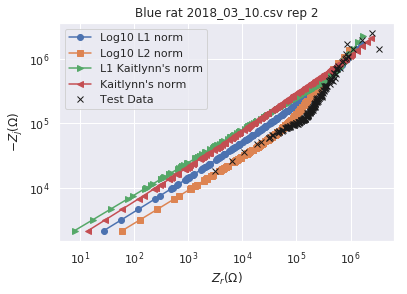

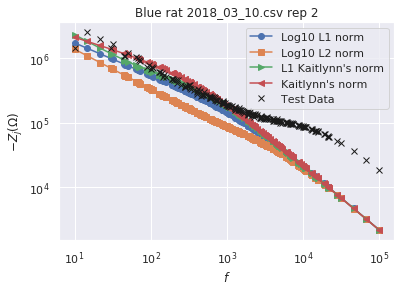

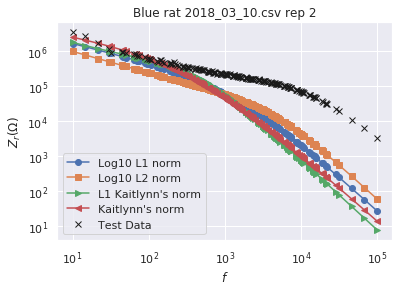

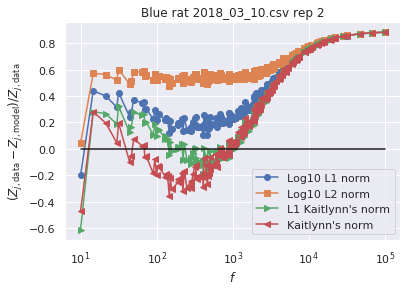

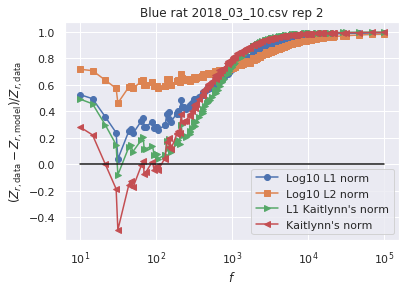

Stored 'res_l1' (ndarray)
Stored 'res_l2' (ndarray)
Stored 'res_lk1' (ndarray)
Stored 'res_lk2' (ndarray)
Stored 'l1_params' (list)
Stored 'l1_opts' (list)
Stored 'l2_params' (list)
Stored 'l2_opts' (list)
Stored 'lk1_params' (list)
Stored 'lk1_opts' (list)
Stored 'lk2_params' (list)
Stored 'lk2_opts' (list)


In [3]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_lk1 = np.zeros((10, 6))
res_lk2 = np.zeros((10, 6))

l1_params = []
l1_opts = []
l2_params = []
l2_opts = []
lk1_params = []
lk1_opts = []
lk2_params = []
lk2_opts = []

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        
        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # remove nans in zr and zj experimental data
        inds = np.where(np.isnan(np.log10(zj)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        inds = np.where(np.isnan(np.log10(zr)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        n = len(f)

        # run log10 optimizations
        xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
        xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

        # reset data values
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]

        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # run normal optimizations
        xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
        xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

        # # save the results into the array
        res_l1[ind*2 + i, :5] = x_l1
        res_l1[ind*2 + i, 5] = opt_l1
        res_l2[ind*2 + i, :5] = x_l2
        res_l2[ind*2 + i, 5] = opt_l2
        res_lk1[ind*2 + i, :5] = x_lk1
        res_lk1[ind*2 + i, 5] = opt_lk1
        res_lk2[ind*2 + i, :5] = x_lk2
        res_lk2[ind*2 + i, 5] = opt_lk2
        
        # append results
        l1_params.append(xs_l1)
        l1_opts.append(opts_l1)
        l2_params.append(xs_l2)
        l2_opts.append(opts_l2)
        lk1_params.append(xs_lk1)
        lk1_opts.append(opts_lk1)
        lk2_params.append(xs_lk2)
        lk2_opts.append(opts_lk2)
        
        plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
             'Blue rat ' + data + ' rep ' + str(i+1))

%store res_l1
%store res_l2
%store res_lk1
%store res_lk2
%store l1_params
%store l1_opts
%store l2_params
%store l2_opts
%store lk1_params
%store lk1_opts
%store lk2_params
%store lk2_opts

# Example results for just one curve

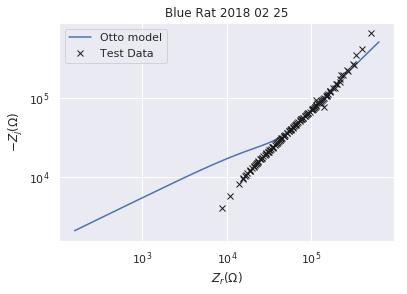

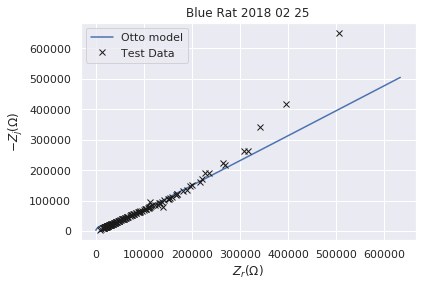

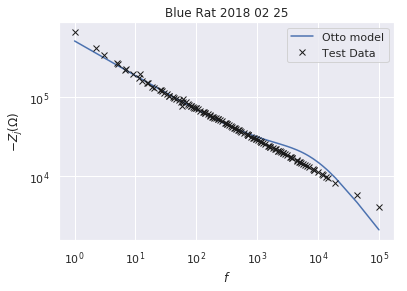

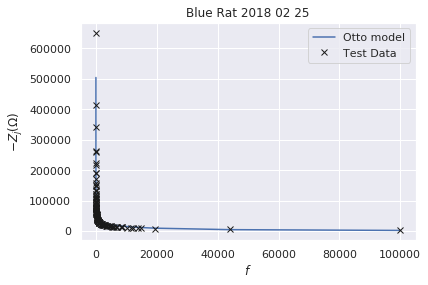

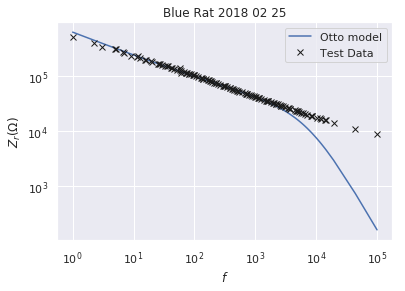

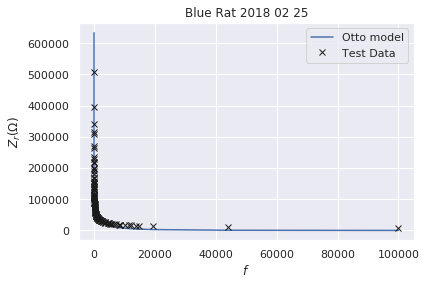

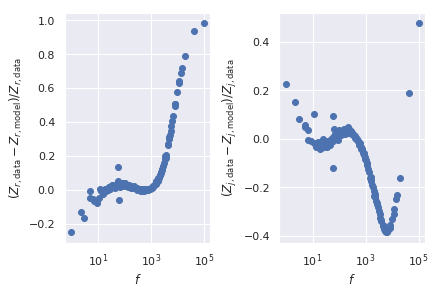

In [4]:
# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

# plot Kaitlynn's norm results
dataset = pd.read_csv(data_prefix+data_list[0])
j = 0*3
f = dataset.values[:, j]
n = len(f)
zr = dataset.values[:, j+1]
zj = dataset.values[:, j+2]
zr_lk, zj_lk = otto_model_create_data(res_l1[0, :5])
title = 'Blue Rat 2018 02 25'
plt.figure()
plt.title(title)
plt.plot(zr_lk, zj_lk, '-', label="Otto model")
plt.plot(zr, zj, 'xk', label='Test Data')

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logrj.pdf', dpi=300, bbox_inches='tight')


plt.figure()
plt.title(title)
plt.plot(zr_lk, zj_lk, '-', label="Otto model")
plt.plot(zr, zj, 'xk', label='Test Data')

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'rj.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj_lk, '-', label="Otto model")
plt.plot(f, zj, 'xk', label='Test Data')

plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logj.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj_lk, '-', label="Otto model")
plt.plot(f, zj, 'xk', label='Test Data')

plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'j.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr_lk, '-', label="Otto model")
plt.plot(f, zr, 'xk', label='Test Data')
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logr.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr_lk, '-', label="Otto model")
plt.plot(f, zr, 'xk', label='Test Data')
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'r.pdf', dpi=300, bbox_inches='tight')
plt.show()

# new plots based on Kaitlynn's suggestion
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(f, (zr-zr_lk)/zr, 'o')
ax[0].set_xscale('log')
ax[0].set_xlabel('$f$')
ax[0].set_ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')

ax[1].plot(f, (zj-zj_lk)/zj, 'o')
ax[1].set_xscale('log')
ax[1].set_xlabel('$f$')
ax[1].set_ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [5]:
columns = ['alpha CPE phase factor','K CPE magnitude factor', 'ren encapsulation resistance (k ohm)', 'rex extracellular resistance (k ohm)', 'am membrane area in cm**2', 'objective value']
index_rows = ['blue rat 2018_02_25 rep 1', 'blue rat 2018_02_25 rep 2', 'blue rat 2018_02_26 rep 1', 'blue rat 2018_02_26 rep 2', 'blue rat 2018_02_27 rep 1', 'blue rat 2018_02_27 rep 2',
             'blue rat 2018_03_03 rep 1', 'blue rat 2018_03_03 rep 2', 'blue rat 2018_03_10 rep 1', 'blue rat 2018_03_10 rep 2']
pd_l1 = pd.DataFrame(res_l1, index=index_rows, columns=columns)
pd_l2 = pd.DataFrame(res_l2, index=index_rows, columns=columns)
pd_lk1 = pd.DataFrame(res_lk1, index=index_rows, columns=columns)
pd_lk2 = pd.DataFrame(res_lk2, index=index_rows, columns=columns)

# Log10 L1 Norm

In [6]:
pd_l1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.438272,0.563601,24.415778,0.0001,1.000000e-10,0.129730
blue rat 2018_02_25 rep 2,0.442069,0.547550,27.248597,0.0001,1.000000e-10,0.135553
blue rat 2018_02_26 rep 1,0.509265,0.416516,42.484869,0.0001,1.000000e-10,0.279558
blue rat 2018_02_26 rep 2,0.509265,0.416516,42.484869,0.0001,1.000000e-10,0.279558
blue rat 2018_02_27 rep 1,0.385164,0.050209,108.889408,0.0001,1.000000e-10,0.898849
blue rat 2018_02_27 rep 2,0.357436,0.060937,81.286803,0.0001,1.000000e-10,0.919501
blue rat 2018_03_03 rep 1,0.572297,0.020117,208.390302,0.0001,1.000000e-10,0.949467
blue rat 2018_03_03 rep 2,0.545227,0.022810,192.713406,0.0001,1.000000e-10,0.945130
blue rat 2018_03_10 rep 1,0.529470,0.041573,156.969649,0.0001,1.000000e-10,1.106472
blue rat 2018_03_10 rep 2,0.504090,0.050903,150.445513,0.0001,1.000000e-10,1.100208


# Log10 L2 Norm

In [7]:
pd_l2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.445694,0.535021,16.335907,0.0001,1.000000e-10,0.229182
blue rat 2018_02_25 rep 2,0.447188,0.526119,17.730588,0.0001,1.000000e-10,0.239896
blue rat 2018_02_26 rep 1,0.521543,0.339414,23.966082,0.0001,1.000000e-10,0.356251
blue rat 2018_02_26 rep 2,0.521543,0.339414,23.966081,0.0001,1.000000e-10,0.356251
blue rat 2018_02_27 rep 1,0.590497,0.027805,68.871237,0.0001,1.000000e-10,0.866484
blue rat 2018_02_27 rep 2,0.576421,0.031226,67.408275,0.0001,1.000307e-10,0.876655
blue rat 2018_03_03 rep 1,0.665210,0.015513,86.140136,0.0001,1.000000e-10,0.814236
blue rat 2018_03_03 rep 2,0.639784,0.017434,83.640457,0.0001,1.000000e-10,0.818617
blue rat 2018_03_10 rep 1,0.607152,0.046080,73.493316,0.0001,1.000000e-10,0.943124
blue rat 2018_03_10 rep 2,0.609114,0.046091,73.013715,0.0001,1.000000e-10,0.942767


# L1 Kaitlynn's Norm

In [8]:
pd_lk1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.438023,0.565634,24.605958,1.000000e-04,1.000000e-10,0.164216
blue rat 2018_02_25 rep 2,0.441956,0.548567,27.442263,1.000000e-04,1.000000e-10,0.168500
blue rat 2018_02_26 rep 1,0.507886,0.426321,44.731392,1.000000e-04,1.000000e-10,0.318204
blue rat 2018_02_26 rep 2,0.507886,0.426321,44.731392,1.000000e-04,4.342389e-07,0.318204
blue rat 2018_02_27 rep 1,0.225242,0.081130,0.010000,1.000000e-04,9.999997e+02,0.556930
blue rat 2018_02_27 rep 2,0.220847,0.081441,0.010000,1.000000e-04,1.000000e+03,0.562427
blue rat 2018_03_03 rep 1,2.001936,0.006691,999.997729,7.217271e+28,5.530274e-06,0.833722
blue rat 2018_03_03 rep 2,0.080994,0.405053,730.311117,8.593399e+29,4.338347e+02,0.824470
blue rat 2018_03_10 rep 1,0.649643,0.024806,624.929626,1.000000e-04,1.000000e-10,0.726176
blue rat 2018_03_10 rep 2,0.639627,0.024696,580.596498,1.000000e-04,1.000000e-10,0.728470


# L2 Kaitlynn's (original) norm

In [9]:
pd_lk2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.499877,0.474499,34.900933,1.000000e-04,1.015625e-10,1.300292e+09
blue rat 2018_02_25 rep 2,0.520781,0.445896,41.961196,1.000000e-04,1.000000e-10,2.083328e+09
blue rat 2018_02_26 rep 1,0.532448,0.292640,45.622042,1.000000e-04,7.813255e-07,7.689999e+11
blue rat 2018_02_26 rep 2,0.532448,0.292640,45.622049,1.000000e-04,1.217500e-06,7.689999e+11
blue rat 2018_02_27 rep 1,0.048512,0.170296,0.010000,9.826489e+29,1.000000e+03,1.474930e+13
blue rat 2018_02_27 rep 2,0.036744,0.149814,0.010000,1.000000e-04,1.000000e+03,3.066113e+13
blue rat 2018_03_03 rep 1,0.313950,0.624542,0.010000,1.000000e-04,1.000000e+03,2.111251e+15
blue rat 2018_03_03 rep 2,0.133215,0.503104,0.010000,1.000000e-04,1.000000e+03,1.427202e+15
blue rat 2018_03_10 rep 1,0.533189,0.030295,440.626685,1.000000e-04,1.000000e-10,1.349814e+12
blue rat 2018_03_10 rep 2,0.410150,0.055262,262.212500,1.000000e-04,1.000000e-10,1.493452e+12
